Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nibabel as nib
from scipy import ndimage

from skimage import io
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import ADASYN

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torchvision import transforms
from torch.utils.data import DataLoader

import albumentations as aug
import cv2

from PIL import Image

import os
import json

import sys

Device Setup:
If you have an Nvidia GPU, you need to install CUDA
Otherwise, CPU will be used

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Hardware to be used:", device)

if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

Hardware to be used: cpu


Directory to Kaggle's Alzheimer MRI Preprocessed Dataset. Link: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset

Alzheimer's Disease Dementia Classes: Non Demented, Very Mild Demented, Mild Demented, Moderate Demented

In [3]:
# ENTER PARENT PATH - Example: C:\\Users\\{USERNAME}\\alzheimer-project-ai4all
parent_path = f"C:\\Users\\Darwin-Xue\\Documents\\Code\\ai4all\\alzheimer-project-ai4all"

kaggle_dir = f"assets\\Kaggle\\alzheimer_mri_preprocessed_dataset"
kaggle_path = os.path.join(parent_path, kaggle_dir)

classes = ["Non_Demented", "Very_Mild_Demented", "Mild_Demented", "Moderate_Demented"]
encoded_classes = {status: idx for idx, status in enumerate(classes)}

# add parent to path
sys.path.append(parent_path)

Loading images and labels (classes)

In [4]:
def load_images(kaggle_path, classes):
    x_img, y_label = [], []
    for class_name in classes:
        class_path = os.path.join(kaggle_path, class_name)

        for image_filename in os.listdir(class_path):
            img = io.imread(os.path.join(class_path, image_filename), as_gray=True)
            x_img.append(img)
            # 0 = Non Demented, 1 = Very Mild Demented, 2 = Mild Demented, 3 = Moderate Demented
            y_label.append(classes.index(class_name))
    
    return np.array(x_img), np.array(y_label)

x, y = load_images(kaggle_path, classes)

Pie Chart of Class Distribution before Data Augmentation and Oversampling

{'Non_Demented': 0, 'Very_Mild_Demented': 1, 'Mild_Demented': 2, 'Moderate_Demented': 3}
(array([0, 1, 2, 3]), array([3200, 2240,  896,   64], dtype=int64))


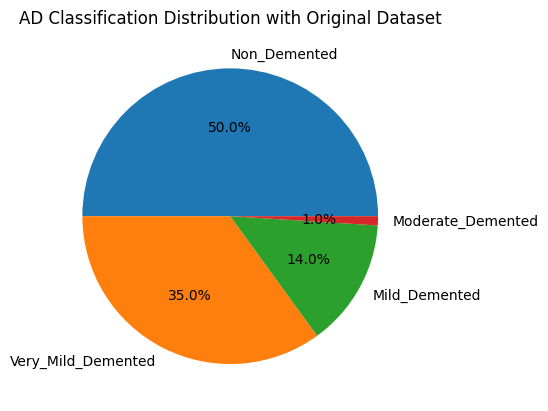

In [5]:
from stats.statistics import Statistics

title = "AD Classification Distribution with Original Dataset"

unique = np.unique(y, return_counts=True)
size = unique[1].tolist()

sample_dist = (classes, size)

print(encoded_classes)
print(unique)
Statistics.pieChartClassificationPlot(sample_dist, title)

To further balance the dataset, we need to employ more techniques. One of which is data augmentation.


In [16]:
from alzheimersdetection.AlzheimerDetection import AlzheimerDataset

data_transforms = aug.Compose(
    [   aug.HorizontalFlip(p=1.0),
        aug.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, border_mode=cv2.BORDER_CONSTANT, value=0, p=0.5),
        aug.RandomBrightnessContrast(brightness_limit=0.0, contrast_limit=0.2, p=0.5)
    ]
)

# Function to augment and save an image
def augment_and_save(image, output_path, transform):
    augmented_image = transform(image=np.array(image))["image"]  # Extract augmented image from Albumentations output
    augmented_image = Image.fromarray(augmented_image)  # Convert back to PIL image
    augmented_image.save(output_path, format="PNG")

for i, (image, label) in enumerate(zip(x, y)):
    transform_dir = f"transformed\\{classes[label]}\\og-{i}.png"
    output_dir = os.path.join(parent_path, transform_dir)
    og_image = Image.fromarray(image)
    og_image.save(output_dir, format="PNG")

    if label == 0: continue
    transform_dir = f"transformed\\{classes[label]}\\{i}.png"
    output_dir = os.path.join(parent_path, transform_dir)
    augment_and_save(image, output_dir, data_transforms)

NameError: name 'cv2' is not defined

Class Distribution after Data Augmentation

{'Non_Demented': 0, 'Very_Mild_Demented': 1, 'Mild_Demented': 2, 'Moderate_Demented': 3}
(array([0, 1, 2, 3]), array([3200, 4480, 1792,  128], dtype=int64))


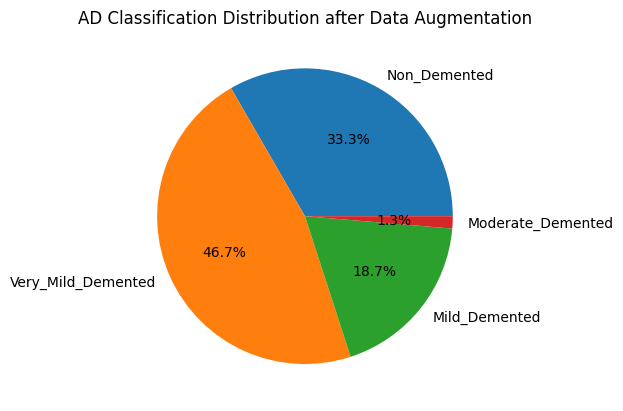

In [7]:
transformed_dir = f"transformed"
transformed_path = os.path.join(parent_path, transformed_dir)
x, y = load_images(transformed_path, classes)

title = "AD Classification Distribution after Data Augmentation"

unique = np.unique(y, return_counts=True)
size = unique[1].tolist()

sample_dist = (classes, size)

print(encoded_classes)
print(unique)
Statistics.pieChartClassificationPlot(sample_dist, title)

Shape Before: (9600, 128, 128)
Shape After:  (9600, 16384)


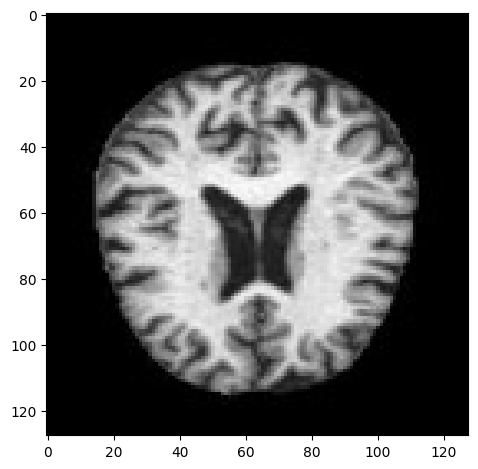

In [8]:
from collections import Counter
io.imshow(x[1])
print("Shape Before:", x.shape)
# Preprocess data (normalize pixel values)
scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x.reshape(-1, x.shape[1] * x.shape[2]))  # Reshape for normalization
print("Shape After: ", x.shape)

In [9]:
train_dataset = AlzheimerDataset(x, y, transform=data_transforms)
val_dataset = AlzheimerDataset(x, y)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

The dataset is still imbalanced and to fix this, we need to increase the minority class's representation (oversampling). This allows us to have a more balanced dataset.

We will be using Adaptive Synthetic Sampling (ADASYN) to oversample the minority classes.

Optimal Results: ~25% distribution across all AD classifications.

AD Classification Distribution before Oversampling
Counter({1: 4480, 0: 3200, 2: 1792, 3: 128})


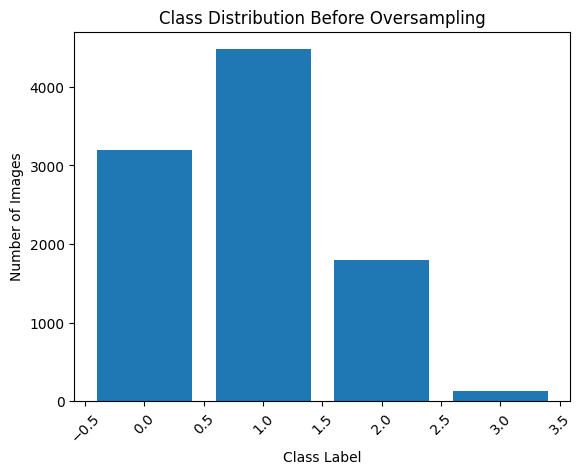

In [10]:
print("AD Classification Distribution before Oversampling")
class_counts = Counter(y)
print(class_counts)

# Visualize class imbalance before oversampling
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution Before Oversampling")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [11]:
k = 5 # This is the k-neighbors which will be used for ADASYN

adasyn = ADASYN(n_neighbors=k)

x_resample, y_resample = adasyn.fit_resample(x, y)
print("Original dataset shape counter: %s" % Counter(y_resample))

Original dataset shape counter: Counter({1: 4480, 3: 4474, 2: 4469, 0: 4434})


In [12]:
print(x_resample.shape)
size = x_resample.shape[0]
X = x_resample.reshape(size, 128, 128)
print(X.shape)

(17857, 16384)
(17857, 128, 128)


AD Classification Distribution after Oversampling
Counter({1: 4480, 3: 4474, 2: 4469, 0: 4434})


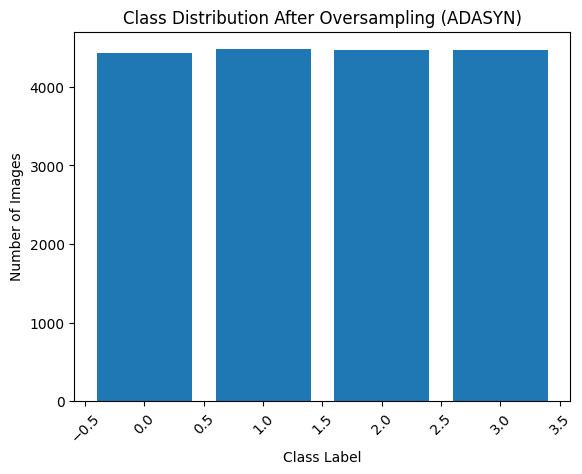

In [13]:
# Combine original and synthetic data
#X_balanced = np.concatenate((x, x_resample))
#y_balanced = np.concatenate((y, y_resample))

# Print class distribution after oversampling
print("AD Classification Distribution after Oversampling")
#class_counts_balanced = Counter(y_balanced)
class_counts_balanced = Counter(y_resample)
print(class_counts_balanced)

# Visualize class distribution after oversampling
plt.bar(class_counts_balanced.keys(), class_counts_balanced.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution After Oversampling (ADASYN)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [14]:
for i, (image, label) in enumerate(zip(X, y_resample)):
    resampled_dir = f"resampled\\{classes[label]}\\{i}.png"
    output_dir = os.path.join(parent_path, resampled_dir)
    image = ((image - image.min()) / (image.max() - image.min()) * 255).astype(np.uint8)
    og_image = Image.fromarray(image)
    og_image.save(output_dir, format="PNG")